# 2D Design Template

# Overview

The purpose of this project is for you to apply what you have learnt in this course. This includes working with data and visualizing it, create model of linear regression, as well as using metrics to measure the accuracy of your model. 

Please find the project handout description in the following [link](https://edimension.sutd.edu.sg/webapps/blackboard/content/listContent.jsp?course_id=_5582_1&content_id=_200537_1).


## Deliverables

You need to submit this Jupyter notebook together with the dataset into Vocareum. Use the template in this notebook to work on this project. You are free to edit or add more cells if needed

## Students Submission
*Include a short sentence summarizing each member’s contribution.*

Student's Name:
- Chen Shixiong - 1009260: Cleaning dataset
- Yeo Owen - 1009253: Found dataset
- Low Wei Yang - 1008921: Build model
- Lee Yi Xiang - 1009335: Evaluated model
- Arman Parkash - 1009174: Perform feature and target preparation

### Problem Statement

- Background description of the problem

With energy demand rising and weather patterns growing more erratic, accurate forecasting of electricity usage has become a critical priority for cities like London. As temperature, humidity, and wind speed shift throughout the year, energy consumption patterns follow suit — affecting everything from heating systems in winter to cooling loads during the warmer months.

This project uses Multiple Linear Regression (MLR) to develop a predictive model of household energy consumption in kilowatt-hours (kWh), based on three key environmental factors: average temperature, humidity, and wind speed. These variables were selected for their measurable impact on energy demand and for the availability of reliable historical data.

By building and comparing the MLR model in Python, the project aims to understand how well these variables explain fluctuations in electricity use in London. The goal is to produce a model that is statistically robust, reproducible, and scalable — offering potential use cases for energy providers, city planners, and policy-makers seeking to optimise energy resources and improve sustainability.

- User Persona

Name: Mary

Age: 72

Location: Tower Hamlets, East London

Occupation: Retired school teacher

Household: Lives alone in a council flat built in the 1970s

Income Level: Low fixed pension

Energy Consumption Behavior:

-- Uses a space heater in winter due to poor insulation

-- Tries to limit energy use, often underheating the home to save costs

-- Relies on weather apps to plan her heating routine

Pain Points:

-- Rising energy prices worsen financial stress

-- Cold, damp winters affect her arthritis and health

-- Does not fully understand smart meter data or energy efficiency programs

-- Lives in a borough with one of the highest fuel poverty rates in London

Values & Motivations:

-- Wants to stay independent and age in place

-- Cares about environmental sustainability but feels excluded from smart energy transitions

- Problem Statement using “how might we ...” statement

How might we predict household energy consumption in London using average temperature, humidity, and wind speed, to improve energy planning and protect vulnerable communities from the effects of climate variability.

### Dataset

- Describe your dataset.
- Put the link to the sources of your raw dataset.
- Put python codes for loading the data into pandas dataframe(s). The data should be the raw data downloaded from the source. No pre-processing using any software (excel, python, etc) yet. Include this dataset in your submission
- Explain each column of your dataset (can use comment or markdown)
- State which column is the dependent variable (target) and explain how it is related to your problem statement
- State which columns are the independent variables (features) and describe your hypothesis on why these features can predict the target variable

[`LCL.csv`](https://data.4tu.nl/datasets/fbbe775b-48d8-469f-a39b-b64488bfd6fd) : 

- This dataset contains half hourly smart meter measurements of 4443 households, obtained during the Low Carbon London project, during 2013.

- Columns:

    DateTime: The date and time of power usage record.

    MAC\d{6}: Household labels' power usage where measurements are in kWh (energy consumption) for the preceding half hour.


[`all_weather_data.csv`](https://www.kaggle.com/datasets/jakewright/2m-daily-weather-history-uk?resource=download): 

- This dataset contains historical weather data from various locations across the UK, spanning from 2009 to 2024. Each entry records the weather conditions for a specific day, providing insights into temperature, rain, humidity, cloud cover, wind speed, and wind direction. The data is useful for analyzing weather patterns and trends over time.

- Columns:

    location: The name of the location (e.g., Holywood, Ardkeen).

    date: The date of the weather record (format: YYYY-MM-DD).

    min_temp (°C): The minimum temperature recorded on that day (in degrees Celsius).

    max_temp (°C): The maximum temperature recorded on that day (in degrees Celsius).

    rain (mm): The amount of rainfall recorded (in millimeters).

    humidity (%): The percentage of humidity.

    cloud_cover (%): The percentage of cloud cover.

    wind_speed (km/h): The wind speed recorded (in kilometers per hour).

    wind_direction: The direction of the wind (e.g., N, SSE, WSW).

    wind_direction_numerical: The numerical representation of the wind direction (e.g., 90.0 for east)


Feature - X data (Independent): Average temperature, Humidity and Wind Speed

Target - Y data (Dependent): Power Usage

#### Import Necessary Libraries

In [263]:
from typing import TypeAlias
from typing import Optional, Any

Number: TypeAlias = int | float

import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message='.*Dtype inference.*')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
from IPython.display import display

#### Import necessary functions from cohort problem sets

In [264]:
def normalize_z(array: np.ndarray, columns_means: Optional[np.ndarray]=None,
                columns_stds: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert columns_means is None or columns_means.shape == (1, array.shape[1])
    assert columns_stds is None or columns_stds.shape == (1, array.shape[1])

    if columns_means is None:
        columns_means = array.mean(axis=0).reshape(1, -1)

    if columns_stds is None:
        columns_stds = array.std(axis=0).reshape(1, -1)

    out: np.ndarray = (array - columns_means) / columns_stds

    assert out.shape == array.shape
    assert columns_means.shape == (1, array.shape[1])
    assert columns_stds.shape == (1, array.shape[1])
    return out, columns_means, columns_stds


def get_features_targets(df: pd.DataFrame,
                         feature_names: list[str],
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_feature: pd.DataFrame = df[feature_names] # if feature_names is not list[str] type and just str, then we will get Series and not Dataframe
    df_target: pd.DataFrame = df[target_names]
    return df_feature, df_target


def prepare_feature(np_feature: np.ndarray) -> np.ndarray:
    cols: int = np_feature.shape[1]
    X: np.ndarray = np.concatenate((np.ones((np_feature.shape[0],1)), np_feature), axis = 1 ) # axis = 1 is to concatenate column wise
    return X


def predict_linreg(array_feature: np.ndarray, beta: np.ndarray,
                   means: Optional[np.ndarray]=None,
                   stds: Optional[np.ndarray]=None) -> np.ndarray:
    assert means is None or means.shape == (1, array_feature.shape[1])
    assert stds is None or stds.shape == (1, array_feature.shape[1])
    norm_data, _, _ = normalize_z(array_feature, means, stds)
    X: np.ndarray = prepare_feature(norm_data)
    result = calc_linreg(X, beta)
    assert result.shape == (array_feature.shape[0], 1)
    return result


def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    result = np.matmul(X, beta)
    assert result.shape == (X.shape[0], 1)
    return result


def compute_cost_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    m = X.shape[0]
    predicted_y = calc_linreg(X, beta)
    error = predicted_y - y
    error_sq = np.matmul(error.T, error)
    J = (1/(2*m)) * error_sq
    assert J.shape == (1, 1)
    return np.squeeze(J)


def gradient_descent_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray,
                            alpha: float, num_iters: int) -> tuple[np.ndarray, np.ndarray]:
    m = X.shape[0]
    J_storage = np.zeros ((num_iters, 1))
    for n in range(num_iters):
        deriv: np.ndarray = np.matmul(X.T, (calc_linreg(X, beta) - y))
        beta = beta - alpha * (1/m) * deriv
        J_storage[n] = compute_cost_linreg(X, y, beta)

    assert beta.shape == (X.shape[1], 1)
    assert J_storage.shape == (num_iters, 1)
    return beta, J_storage


def split_data(df_feature: pd.DataFrame, df_target: pd.DataFrame,
               random_state: Optional[int]=None,
               test_size: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    index = df_feature.index

    if random_state is not None:
        np.random.seed(random_state)

    rows_test_size = int(test_size * len(index))

    # Sample the test index dataset
    test_index = np.random.choice(index, rows_test_size, replace = False)
    remaining_index_from_test = index.drop(test_index)

    # Divide the remaining index into 80% train set and 20% validation set
    validation_index_size = int(0.2 * len(remaining_index_from_test))
    validation_index = np.random.choice(remaining_index_from_test, validation_index_size, replace = False)
    train_index = remaining_index_from_test.drop(validation_index)

    # Select data for the output
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index,:]
    df_feature_validation = df_feature.loc[validation_index, :]
    df_target_train = df_target.loc[train_index,:]
    df_target_test = df_target.loc[test_index,:]
    df_target_validation = df_target.loc[validation_index, :]

    return df_feature_train, df_feature_test, df_target_train, df_target_test, df_feature_validation, df_target_validation


# just wrap all the code in CS4 in a function
def build_model_linreg(df_feature_train: pd.DataFrame,
                       df_target_train: pd.DataFrame,
                       beta: Optional[np.ndarray] = None,
                       alpha: float = 0.01,
                       iterations: int = 1500) -> tuple[dict[str, Any], np.ndarray]:
    # check if initial beta values are given
    if beta is None:
        beta = np.zeros((df_feature_train.shape[1]+1, 1)) # add one dimension to the feature_train array because of the b0 coefficient
    assert beta.shape == (df_feature_train.shape[1]+1, 1) # to make sure if beta argument is given, then it conforms to the shape of the feature train

    array_feature_train_z, means, stds = normalize_z(df_feature_train.to_numpy())

    # prepare the X matrix and the target vector as ndarray
    X: np.ndarray = prepare_feature(array_feature_train_z)
    target: np.ndarray = df_target_train.to_numpy()
    beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)
    # store the output in model dictionary
    model = {"beta": beta, "means":means, "stds": stds}

    # assert the shapes
    assert model["beta"].shape == (df_feature_train.shape[1] + 1, 1) # make sure that beta vector is d by 1
    assert model["means"].shape == (1, df_feature_train.shape[1]) # make sure that the means vector is also d-1 by 1 (1 per feature)
    assert model["stds"].shape == (1, df_feature_train.shape[1])  # make sure that the stds vector is also d-1 by 1 (1 per feature)
    assert J_storage.shape == (iterations, 1) # make sure we have recorded #iterations of error
    return model, J_storage


def r2_score(y: np.ndarray, ypred: np.ndarray) -> float:
    res = np.sum((y - ypred)**2)
    tot = np.sum((y - y.mean())**2)
    return 1 - res / tot


def mean_squared_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sum((target - pred)**2)/target.shape[0]

#### Loading Raw Data

In [265]:
df1 = pd.read_csv('./LCL_2013.csv')

df1

,DateTime,MAC000002,MAC000003,MAC000004,MAC000006,MAC000007,MAC000008,MAC000009,MAC000010,MAC000011,...,MAC005555,MAC005556,MAC005558,MAC005559,MAC005560,MAC005561,MAC005562,MAC005563,MAC005566,MAC005567
0,2013-01-01 00:30:00.0000000,0.241,1.922,0.000,0.000,0.204,0.245,0.176,0.453,0.301,...,0.134,NaN,NaN,NaN,NaN,0.050,0.249,NaN,0.075,0.066
1,2013-01-01 01:00:00.0000000,0.191,1.808,0.000,0.000,0.161,0.263,0.147,0.500,0.657,...,0.090,NaN,NaN,NaN,NaN,0.086,0.282,NaN,0.116,0.046
2,2013-01-01 01:30:00.0000000,0.235,0.795,0.158,0.000,0.214,0.261,0.093,0.621,0.683,...,0.141,NaN,NaN,NaN,NaN,0.045,0.192,NaN,0.111,0.057
3,2013-01-01 02:00:00.0000000,0.182,1.235,0.000,0.000,0.186,0.255,0.088,0.197,0.658,...,0.125,NaN,NaN,NaN,NaN,0.048,0.204,NaN,0.104,0.160
4,2013-01-01 02:30:00.0000000,0.229,0.924,0.000,0.000,0.126,0.270,0.145,0.176,0.773,...,0.111,NaN,NaN,NaN,NaN,0.083,0.048,NaN,0.116,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2013-12-31 22:00:00.0000000,0.456,0.391,0.000,0.076,0.312,NaN,0.103,0.697,0.403,...,0.117,NaN,0.024,NaN,NaN,0.163,0.430,NaN,0.098,0.050
17516,2013-12-31 22:30:00.0000000,0.402,0.093,0.000,0.078,0.420,NaN,0.099,0.779,0.372,...,0.130,NaN,0.025,NaN,NaN,0.119,0.444,NaN,0.072,0.051
17517,2013-12-31 23:00:00.0000000,0.491,0.060,0.000,0.040,0.338,NaN,0.200,0.851,0.401,...,0.084,NaN,0.025,NaN,NaN,0.097,0.539,NaN,0.103,0.057
17518,2013-12-31 23:30:00.0000000,0.452,0.089,0.157,0.073,0.384,NaN,0.132,0.850,0.438,...,0.097,NaN,0.025,NaN,NaN,0.090,0.461,NaN,0.065,0.062


In [266]:
df2 = pd.read_csv('./all_weather_data.csv')

df2

,location,date,min_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction,wind_direction_numerical
0,Holywood,2009-01-01,0.0,3.0,0.0,86.0,14.0,12.0,E,90.0
1,North Cray,2009-01-01,-3.0,2.0,0.0,93.0,44.0,8.0,NNE,22.5
2,Portknockie,2009-01-01,2.0,4.0,0.8,88.0,87.0,10.0,ESE,112.5
3,Blairskaith,2009-01-01,-3.0,1.0,0.0,86.0,43.0,12.0,ENE,67.5
4,Onehouse,2009-01-01,-1.0,3.0,0.0,91.0,63.0,7.0,S,180.0
...,...,...,...,...,...,...,...,...,...,...
2836181,Ardkeen,2024-11-08,12.0,13.0,0.0,91.0,44.0,18.0,SSE,157.5
2836182,Ardkeen,2024-11-09,11.0,13.0,0.2,89.0,75.0,17.0,SSE,157.5
2836183,Ardkeen,2024-11-10,9.0,14.0,0.5,90.0,68.0,17.0,WSW,247.5
2836184,Ardkeen,2024-11-11,8.0,11.0,0.0,83.0,18.0,12.0,NW,315.0


### Clean & Analyze your data
Use python code to:
- Clean your data
- Calculate Descriptive Statistics and other statistical analysis
- Visualization with meaningful analysis description

#### `LCL.csv` (Average Household Power Usage)

1. Compute average energy average usage across all households.
2. Convert energy usage data into daily scale.

In [267]:
# Create a proper copy of the dataframe and ensure clean dtypes
df1_pp = df1.iloc[:-1].copy()

# Drop columns where there are households with readings that are NaN
df1_pp = df1_pp.dropna(axis='columns', how='any')

# Convert DateTime column into datetime format with explicit parameters
df1_pp.loc[:, 'DateTime'] = pd.to_datetime(df1_pp['DateTime'], format='mixed', errors='coerce')

# Set index and ensure it's properly typed
df1_pp = df1_pp.set_index('DateTime')

# Resample by day ('D') and sum each column (i.e. each household)
df_daily = df1_pp.resample('D').sum()

# Reset index so 'DateTime' becomes a column again
df_daily = df_daily.reset_index()

# Exclude non-household columns (e.g., 'DateTime')
mac_columns = [col for col in df_daily.columns if col.startswith('MAC')]

# Compute row-wise average across all MAC* columns
df_daily['Household Average'] = df_daily[mac_columns].mean(axis=1, skipna=True)

# Create final dataframe with just DateTime and average
df_daily_average = df_daily[['DateTime', 'Household Average']].copy()

In [268]:
display(df_daily_average), display(df_daily_average.describe())

,DateTime,Household Average
0,2013-01-01,12.755195
1,2013-01-02,13.173184
2,2013-01-03,12.357839
3,2013-01-04,12.479354
4,2013-01-05,12.985994
...,...,...
360,2013-12-27,13.078124
361,2013-12-28,12.791791
362,2013-12-29,13.226031
363,2013-12-30,13.167175


,DateTime,Household Average
count,365,365.000000
mean,2013-07-02 00:00:00,10.933100
min,2013-01-01 00:00:00,8.064303
25%,2013-04-02 00:00:00,9.065096
50%,2013-07-02 00:00:00,10.334360
75%,2013-10-01 00:00:00,12.755195
max,2013-12-31 00:00:00,16.390672
std,NaN,2.078897


(None, None)

#### `all_weather_data.csv` (Weather stats in London)

1. Filter data to include only records from the year 2013.
2. Select London data only.

In [269]:
df2_pp = df2.copy()

# Filter for London AND year 2013 in one operation
df2_london_2013 = df2_pp[
    (df2_pp['location'] == 'London') &
    (pd.to_datetime(df2_pp['date']).dt.year == 2013)
].copy()

df2_london_2013['average_temp °c'] = (df2_london_2013['min_temp °c'] + df2_london_2013['max_temp °c']) / 2

# Ensure date column is datetime format
df2_london_2013['date'] = pd.to_datetime(df2_london_2013['date'])

column_order = [
    'location', 'date', 'min_temp °c', 'average_temp °c', 'max_temp °c',
    'rain mm', 'humidity %', 'cloud_cover %', 'wind_speed km/h',
    'wind_direction', 'wind_direction_numerical'
]

# Reorder the dataframe
df2_london_2013 = df2_london_2013[column_order]

In [270]:
display(df2_london_2013), display(df2_london_2013.describe())

,location,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction,wind_direction_numerical
734579,London,2013-01-01,3.0,5.5,8.0,0.3,90.0,26.0,18.0,W,270.0
735289,London,2013-01-02,3.0,6.0,9.0,0.3,96.0,64.0,16.0,WSW,247.5
735709,London,2013-01-03,8.0,10.0,12.0,0.0,95.0,61.0,17.0,W,270.0
736261,London,2013-01-04,6.0,8.0,10.0,0.0,94.0,55.0,14.0,W,270.0
736785,London,2013-01-05,5.0,7.5,10.0,0.1,96.0,80.0,10.0,WSW,247.5
...,...,...,...,...,...,...,...,...,...,...,...
915859,London,2013-12-27,5.0,7.5,10.0,5.9,87.0,41.0,30.0,SSW,202.5
916372,London,2013-12-28,2.0,4.5,7.0,0.0,86.0,23.0,14.0,SW,225.0
916753,London,2013-12-29,1.0,3.5,6.0,0.0,90.0,22.0,16.0,WSW,247.5
917515,London,2013-12-30,6.0,7.5,9.0,4.3,92.0,68.0,28.0,SSW,202.5


,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction_numerical
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2013-07-02 00:00:00,6.180822,9.954795,13.728767,1.837260,83.065753,53.375342,13.967123,186.842466
min,2013-01-01 00:00:00,-6.000000,-3.000000,0.000000,0.000000,55.000000,0.000000,4.000000,22.500000
25%,2013-04-02 00:00:00,2.000000,5.000000,8.000000,0.000000,76.000000,35.000000,10.000000,112.500000
50%,2013-07-02 00:00:00,6.000000,9.500000,13.000000,0.100000,85.000000,54.000000,13.000000,202.500000
75%,2013-10-01 00:00:00,11.000000,15.000000,19.000000,2.000000,91.000000,71.000000,17.000000,247.500000
max,2013-12-31 00:00:00,18.000000,24.000000,31.000000,31.700000,98.000000,100.000000,33.000000,337.500000
std,NaN,5.453617,6.216670,7.219888,3.709275,8.956614,23.467863,5.596213,85.084875


(None, None)

#### Seasonal Classification

1. Correlate both datasets base on date.
2. Segment dataset by season for further analysis.

In [271]:
# Add season classification
def get_season(date):
    """
    Classify date into seasons based on meteorological seasons:
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June, July, August
    - Fall/Autumn: September, October, November
    """
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Fall'

In [272]:
# Apply season classification using .loc to avoid warning
df_daily_average.loc[:, 'Season'] = df_daily_average['DateTime'].apply(get_season)

# Split data into seasonal dataframes
winter_data = df_daily_average[df_daily_average['Season'] == 'Winter'].copy()
spring_data = df_daily_average[df_daily_average['Season'] == 'Spring'].copy()
summer_data = df_daily_average[df_daily_average['Season'] == 'Summer'].copy()
fall_data = df_daily_average[df_daily_average['Season'] == 'Fall'].copy()

In [273]:
# Add season column
df2_london_2013['season'] = df2_london_2013['date'].apply(get_season)

# Split data into seasonal dataframes
winter_weather = df2_london_2013[df2_london_2013['season'] == 'Winter'].copy()
spring_weather = df2_london_2013[df2_london_2013['season'] == 'Spring'].copy()
summer_weather = df2_london_2013[df2_london_2013['season'] == 'Summer'].copy()
fall_weather = df2_london_2013[df2_london_2013['season'] == 'Fall'].copy()

In [274]:
winter_data = pd.merge(
    winter_data,           # energy data with 'DateTime' and 'Household Average'
    winter_weather,        # weather data with 'date' and 'average_temp'
    left_on='DateTime',    # date column in energy data
    right_on='date',       # date column in weather data
    how='inner'            # only dates that exist in both datasets
)

spring_data = pd.merge(
    spring_data,           # energy data with 'DateTime' and 'Household Average'
    spring_weather,        # weather data with 'date' and 'average_temp'
    left_on='DateTime',    # date column in energy data
    right_on='date',       # date column in weather data
    how='inner'            # only dates that exist in both datasets
)

summer_data = pd.merge(
    summer_data,           # energy data with 'DateTime' and 'Household Average'
    summer_weather,        # weather data with 'date' and 'average_temp'
    left_on='DateTime',    # date column in energy data
    right_on='date',       # date column in weather data
    how='inner'            # only dates that exist in both datasets
)

fall_data = pd.merge(
    fall_data,           # energy data with 'DateTime' and 'Household Average'
    fall_weather,        # weather data with 'date' and 'average_temp'
    left_on='DateTime',    # date column in energy data
    right_on='date',       # date column in weather data
    how='inner'            # only dates that exist in both datasets
)

In [275]:
display(winter_data), display(winter_data.describe())
display(spring_data), display(spring_data.describe())
display(summer_data), display(summer_data.describe())
display(fall_data), display(fall_data.describe())

,DateTime,Household Average,Season,location,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction,wind_direction_numerical,season
0,2013-01-01,12.755195,Winter,London,2013-01-01,3.0,5.5,8.0,0.3,90.0,26.0,18.0,W,270.0,Winter
1,2013-01-02,13.173184,Winter,London,2013-01-02,3.0,6.0,9.0,0.3,96.0,64.0,16.0,WSW,247.5,Winter
2,2013-01-03,12.357839,Winter,London,2013-01-03,8.0,10.0,12.0,0.0,95.0,61.0,17.0,W,270.0,Winter
3,2013-01-04,12.479354,Winter,London,2013-01-04,6.0,8.0,10.0,0.0,94.0,55.0,14.0,W,270.0,Winter
4,2013-01-05,12.985994,Winter,London,2013-01-05,5.0,7.5,10.0,0.1,96.0,80.0,10.0,WSW,247.5,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2013-12-27,13.078124,Winter,London,2013-12-27,5.0,7.5,10.0,5.9,87.0,41.0,30.0,SSW,202.5,Winter
86,2013-12-28,12.791791,Winter,London,2013-12-28,2.0,4.5,7.0,0.0,86.0,23.0,14.0,SW,225.0,Winter
87,2013-12-29,13.226031,Winter,London,2013-12-29,1.0,3.5,6.0,0.0,90.0,22.0,16.0,WSW,247.5,Winter
88,2013-12-30,13.167175,Winter,London,2013-12-30,6.0,7.5,9.0,4.3,92.0,68.0,28.0,SSW,202.5,Winter


,DateTime,Household Average,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction_numerical
count,90,90.000000,90,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,2013-05-20 05:20:00,13.381884,2013-05-20 05:20:00,1.577778,4.094444,6.611111,1.758889,89.811111,56.822222,16.400000,188.750000
min,2013-01-01 00:00:00,11.917518,2013-01-01 00:00:00,-6.000000,-3.000000,0.000000,0.000000,71.000000,13.000000,4.000000,22.500000
25%,2013-01-23 06:00:00,12.622610,2013-01-23 06:00:00,-1.000000,2.000000,4.000000,0.000000,87.000000,37.250000,12.250000,135.000000
50%,2013-02-14 12:00:00,13.195831,2013-02-14 12:00:00,1.500000,4.500000,8.000000,0.050000,90.500000,57.000000,16.000000,202.500000
75%,2013-12-08 18:00:00,14.038392,2013-12-08 18:00:00,4.000000,6.500000,9.000000,2.350000,94.000000,73.000000,19.750000,247.500000
max,2013-12-31 00:00:00,16.390672,2013-12-31 00:00:00,9.000000,10.500000,13.000000,15.200000,98.000000,100.000000,33.000000,337.500000
std,NaN,0.931525,NaN,3.311464,3.285048,3.437057,3.007926,5.723781,22.457739,6.502895,81.418473


,DateTime,Household Average,Season,location,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction,wind_direction_numerical,season
0,2013-03-01,13.231043,Spring,London,2013-03-01,1.0,4.5,8.0,0.0,85.0,72.0,14.0,NNE,22.5,Spring
1,2013-03-02,13.500141,Spring,London,2013-03-02,0.0,3.5,7.0,0.0,82.0,22.0,7.0,NNE,22.5,Spring
2,2013-03-03,13.984091,Spring,London,2013-03-03,0.0,3.5,7.0,0.0,85.0,39.0,10.0,E,90.0,Spring
3,2013-03-04,12.532857,Spring,London,2013-03-04,0.0,4.5,9.0,0.0,86.0,30.0,14.0,E,90.0,Spring
4,2013-03-05,11.790207,Spring,London,2013-03-05,2.0,8.5,15.0,0.0,85.0,25.0,9.0,SE,135.0,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2013-05-27,9.282986,Spring,London,2013-05-27,6.0,11.0,16.0,0.0,70.0,9.0,15.0,SSW,202.5,Spring
88,2013-05-28,9.632911,Spring,London,2013-05-28,7.0,10.0,13.0,14.2,96.0,95.0,8.0,SE,135.0,Spring
89,2013-05-29,9.691630,Spring,London,2013-05-29,7.0,9.5,12.0,1.4,92.0,94.0,9.0,WNW,292.5,Spring
90,2013-05-30,9.577498,Spring,London,2013-05-30,9.0,11.5,14.0,1.2,96.0,97.0,13.0,W,270.0,Spring


,DateTime,Household Average,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction_numerical
count,92,92.000000,92,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,2013-04-15 12:00:00,11.243856,2013-04-15 12:00:00,3.010870,7.076087,11.141304,1.691304,81.130435,58.706522,14.576087,159.701087
min,2013-03-01 00:00:00,8.799730,2013-03-01 00:00:00,-3.000000,-0.500000,1.000000,0.000000,63.000000,0.000000,6.000000,22.500000
25%,2013-03-23 18:00:00,9.606076,2013-03-23 18:00:00,0.000000,3.500000,7.000000,0.000000,75.000000,42.500000,10.000000,67.500000
50%,2013-04-15 12:00:00,10.845912,2013-04-15 12:00:00,3.000000,8.000000,12.000000,0.100000,80.500000,62.000000,14.000000,168.750000
75%,2013-05-08 06:00:00,12.928674,2013-05-08 06:00:00,6.000000,10.000000,15.000000,1.900000,87.000000,78.000000,18.000000,230.625000
max,2013-05-31 00:00:00,15.649607,2013-05-31 00:00:00,10.000000,15.500000,21.000000,14.200000,97.000000,100.000000,29.000000,337.500000
std,NaN,1.795192,NaN,3.754834,4.157566,4.960462,2.887474,8.057782,24.463715,5.421232,93.222116


,DateTime,Household Average,Season,location,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction,wind_direction_numerical,season
0,2013-06-01,9.255494,Summer,London,2013-06-01,8.0,12.5,17.0,0.0,74.0,36.0,13.0,WNW,292.5,Summer
1,2013-06-02,9.489014,Summer,London,2013-06-02,7.0,12.0,17.0,0.1,73.0,32.0,11.0,WSW,247.5,Summer
2,2013-06-03,8.805950,Summer,London,2013-06-03,6.0,12.0,18.0,0.0,73.0,14.0,11.0,NE,45.0,Summer
3,2013-06-04,8.603194,Summer,London,2013-06-04,5.0,11.5,18.0,0.0,74.0,19.0,15.0,NE,45.0,Summer
4,2013-06-05,8.619613,Summer,London,2013-06-05,7.0,13.5,20.0,0.0,79.0,35.0,11.0,NE,45.0,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2013-08-27,8.380378,Summer,London,2013-08-27,12.0,17.5,23.0,0.0,70.0,2.0,8.0,ESE,112.5,Summer
88,2013-08-28,8.324778,Summer,London,2013-08-28,12.0,18.0,24.0,0.0,70.0,9.0,5.0,SE,135.0,Summer
89,2013-08-29,8.332622,Summer,London,2013-08-29,14.0,19.0,24.0,0.0,71.0,34.0,8.0,W,270.0,Summer
90,2013-08-30,8.453169,Summer,London,2013-08-30,15.0,19.0,23.0,0.6,78.0,52.0,12.0,WSW,247.5,Summer


,DateTime,Household Average,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction_numerical
count,92,92.000000,92,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,2013-07-16 12:00:00,8.629172,2013-07-16 12:00:00,12.141304,17.233696,22.326087,1.545652,75.043478,45.684783,11.673913,178.777174
min,2013-06-01 00:00:00,8.064303,2013-06-01 00:00:00,5.000000,11.500000,14.000000,0.000000,55.000000,2.000000,5.000000,22.500000
25%,2013-06-23 18:00:00,8.372675,2013-06-23 18:00:00,10.000000,15.500000,20.000000,0.000000,70.000000,27.750000,8.000000,129.375000
50%,2013-07-16 12:00:00,8.580315,2013-07-16 12:00:00,12.000000,17.500000,22.000000,0.000000,74.000000,47.000000,11.500000,202.500000
75%,2013-08-08 06:00:00,8.779301,2013-08-08 06:00:00,14.000000,19.000000,25.000000,0.825000,79.000000,63.250000,14.000000,247.500000
max,2013-08-31 00:00:00,9.886850,2013-08-31 00:00:00,18.000000,24.000000,31.000000,31.700000,94.000000,97.000000,23.000000,337.500000
std,NaN,0.351248,NaN,2.857731,3.117172,3.849101,4.639662,7.683167,23.270946,4.124728,84.475185


,DateTime,Household Average,Season,location,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction,wind_direction_numerical,season
0,2013-09-01,9.130749,Fall,London,2013-09-01,10.0,15.5,21.0,0.0,64.0,33.0,11.0,WNW,292.5,Fall
1,2013-09-02,8.577183,Fall,London,2013-09-02,10.0,17.0,24.0,0.0,77.0,13.0,11.0,WNW,292.5,Fall
2,2013-09-03,8.570824,Fall,London,2013-09-03,15.0,20.0,25.0,0.2,79.0,35.0,5.0,S,180.0,Fall
3,2013-09-04,8.565468,Fall,London,2013-09-04,14.0,20.5,27.0,0.0,79.0,9.0,7.0,SE,135.0,Fall
4,2013-09-05,8.685421,Fall,London,2013-09-05,16.0,22.0,28.0,0.0,73.0,9.0,5.0,S,180.0,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2013-11-26,12.275301,Fall,London,2013-11-26,0.0,3.0,6.0,0.0,92.0,42.0,10.0,NW,315.0,Fall
87,2013-11-27,12.179440,Fall,London,2013-11-27,2.0,5.5,9.0,0.2,97.0,95.0,6.0,WSW,247.5,Fall
88,2013-11-28,11.988445,Fall,London,2013-11-28,4.0,6.0,8.0,0.0,96.0,75.0,7.0,SSW,202.5,Fall
89,2013-11-29,12.030456,Fall,London,2013-11-29,4.0,7.0,10.0,0.1,91.0,75.0,17.0,W,270.0,Fall


,DateTime,Household Average,date,min_temp °c,average_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h,wind_direction_numerical
count,91,91.000000,91,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,2013-10-16 00:00:00,10.526303,2013-10-16 00:00:00,7.912088,11.302198,14.692308,2.357143,86.461538,52.351648,13.263736,220.549451
min,2013-09-01 00:00:00,8.565468,2013-09-01 00:00:00,-1.000000,2.000000,5.000000,0.000000,64.000000,8.000000,4.000000,67.500000
25%,2013-09-23 12:00:00,9.522973,2013-09-23 12:00:00,5.000000,8.250000,11.500000,0.000000,83.000000,35.000000,10.000000,180.000000
50%,2013-10-16 00:00:00,10.271410,2013-10-16 00:00:00,8.000000,12.000000,15.000000,0.400000,87.000000,53.000000,13.000000,225.000000
75%,2013-11-07 12:00:00,11.576826,2013-11-07 12:00:00,11.000000,14.750000,18.000000,3.100000,91.000000,67.500000,16.500000,270.000000
max,2013-11-30 00:00:00,13.524834,2013-11-30 00:00:00,16.000000,22.000000,28.000000,21.100000,97.000000,96.000000,28.000000,337.500000
std,NaN,1.244727,NaN,4.015659,4.418320,5.028126,4.014395,6.319824,21.761522,5.074632,68.920044


(None, None)

In [276]:
# visualization with analysis

### Features and Target Preparation

Prepare features and target for model training.

In [277]:
# put Python code to prepare your features and target
FEATURE_NAMES = ["average_temp °c", "humidity %", "wind_speed km/h"]
TARGET_NAMES = ["Household Average"]

df_feature_winter, df_target_winter = get_features_targets(winter_data, FEATURE_NAMES, TARGET_NAMES)
df_feature_spring, df_target_spring = get_features_targets(spring_data, FEATURE_NAMES, TARGET_NAMES)
df_feature_summer, df_target_summer = get_features_targets(summer_data, FEATURE_NAMES, TARGET_NAMES)
df_feature_fall, df_target_fall =     get_features_targets(fall_data, FEATURE_NAMES, TARGET_NAMES)

In [278]:
array_feature_winter, _, _ = normalize_z(df_feature_winter.to_numpy())
array_feature_spring, _, _ = normalize_z(df_feature_spring.to_numpy())
array_feature_summer, _, _ = normalize_z(df_feature_summer.to_numpy())
array_feature_fall, _, _ = normalize_z(df_feature_fall.to_numpy())

In [279]:
df_features_winter: pd.DataFrame = pd.DataFrame(array_feature_winter, columns=df_feature_winter.columns)
display(df_features_winter.describe()), display(df_target_winter.describe())

df_features_spring: pd.DataFrame = pd.DataFrame(array_feature_spring, columns=df_feature_spring.columns)
display(df_features_spring.describe()), display(df_target_spring.describe())

df_features_summer: pd.DataFrame = pd.DataFrame(array_feature_summer, columns=df_feature_summer.columns)
display(df_features_summer.describe()), display(df_target_summer.describe())

df_features_fall: pd.DataFrame = pd.DataFrame(array_feature_fall, columns=df_feature_fall.columns)
display(df_features_fall.describe()), display(df_target_fall.describe())

,average_temp °c,humidity %,wind_speed km/h
count,9.000000e+01,9.000000e+01,9.000000e+01
mean,8.881784e-17,-1.049778e-15,2.023073e-16
std,1.005602e+00,1.005602e+00,1.005602e+00
min,-2.171715e+00,-3.304895e+00,-1.917526e+00
25%,-6.411407e-01,-4.938798e-01,-6.417526e-01
50%,1.241466e-01,1.210298e-01,-6.185567e-02
75%,7.363765e-01,7.359394e-01,5.180412e-01
max,1.960836e+00,1.438693e+00,2.567010e+00


,Household Average
count,90.000000
mean,13.381884
std,0.931525
min,11.917518
25%,12.622610
50%,13.195831
75%,14.038392
max,16.390672


,average_temp °c,humidity %,wind_speed km/h
count,9.200000e+01,9.200000e+01,9.200000e+01
mean,-4.827057e-18,-8.495620e-16,1.279170e-16
std,1.005479e+00,1.005479e+00,1.005479e+00
min,-1.832226e+00,-2.262382e+00,-1.590613e+00
25%,-8.648527e-01,-7.649780e-01,-8.487300e-01
50%,2.234422e-01,-7.866795e-02,-1.068472e-01
75%,7.071288e-01,7.324258e-01,6.350355e-01
max,2.037267e+00,1.980262e+00,2.675213e+00


,Household Average
count,92.000000
mean,11.243856
std,1.795192
min,8.799730
25%,9.606076
50%,10.845912
75%,12.928674
max,15.649607


,average_temp °c,humidity %,wind_speed km/h
count,9.200000e+01,9.200000e+01,9.200000e+01
mean,-2.721253e-16,3.089316e-16,-1.894620e-16
std,1.005479e+00,1.005479e+00,1.005479e+00
min,-1.849469e+00,-2.623047e+00,-1.626891e+00
25%,-5.592233e-01,-6.600291e-01,-8.955850e-01
50%,8.589950e-02,-1.365577e-01,-4.239456e-02
75%,5.697416e-01,5.177815e-01,5.670272e-01
max,2.182549e+00,2.480799e+00,2.760946e+00


,Household Average
count,92.000000
mean,8.629172
std,0.351248
min,8.064303
25%,8.372675
50%,8.580315
75%,8.779301
max,9.886850


,average_temp °c,humidity %,wind_speed km/h
count,9.100000e+01,9.100000e+01,9.100000e+01
mean,-1.903239e-16,-8.808583e-16,-1.708035e-16
std,1.005540e+00,1.005540e+00,1.005540e+00
min,-2.117034e+00,-3.573831e+00,-1.835613e+00
25%,-6.946323e-01,-5.507616e-01,-6.467105e-01
50%,1.588088e-01,8.567402e-02,-5.225944e-02
75%,7.846656e-01,7.221096e-01,6.412668e-01
max,2.434652e+00,1.676763e+00,2.919996e+00


,Household Average
count,91.000000
mean,10.526303
std,1.244727
min,8.565468
25%,9.522973
50%,10.271410
75%,11.576826
max,13.524834


(None, None)

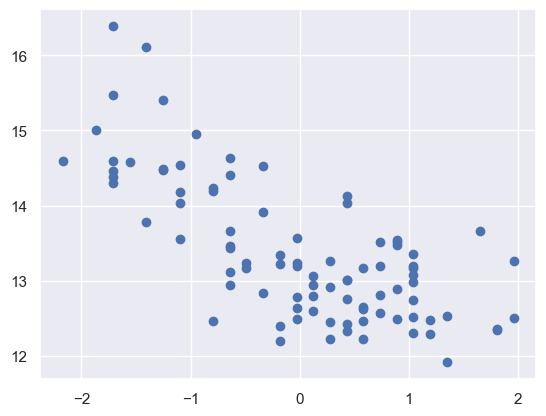

In [280]:
sns.set()
plt.scatter(df_features_winter["average_temp °c"], df_target_winter)

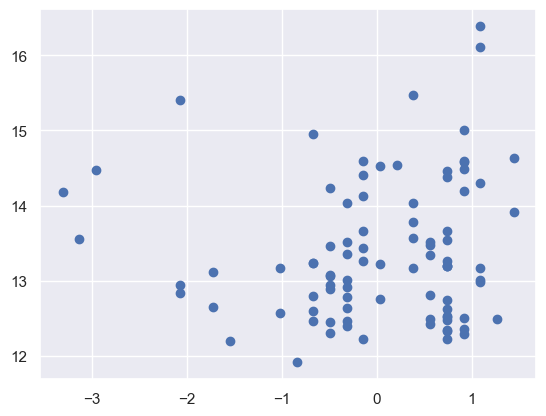

In [281]:
sns.set()
plt.scatter(df_features_winter["humidity %"], df_target_winter)

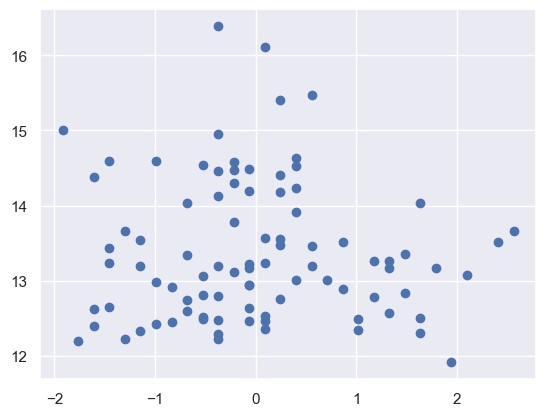

In [282]:
sns.set()
plt.scatter(df_features_winter["wind_speed km/h"], df_target_winter)

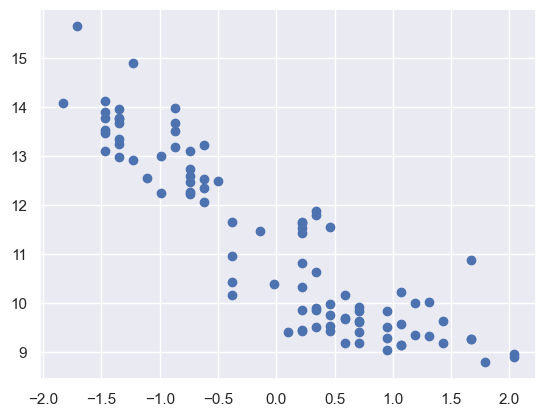

In [283]:
sns.set()
plt.scatter(df_features_spring["average_temp °c"], df_target_spring)

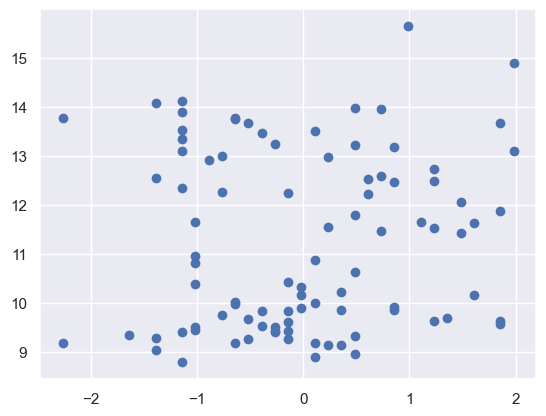

In [284]:
sns.set()
plt.scatter(df_features_spring["humidity %"], df_target_spring)

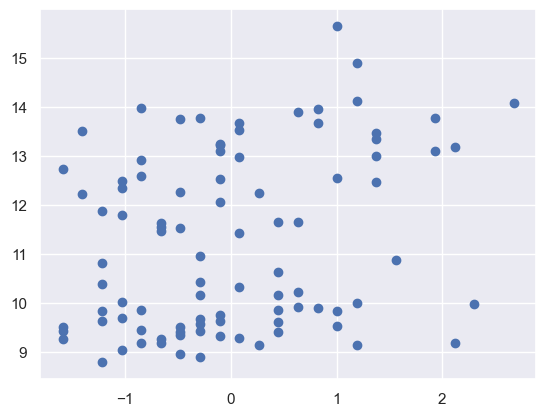

In [285]:
sns.set()
plt.scatter(df_features_spring["wind_speed km/h"], df_target_spring)

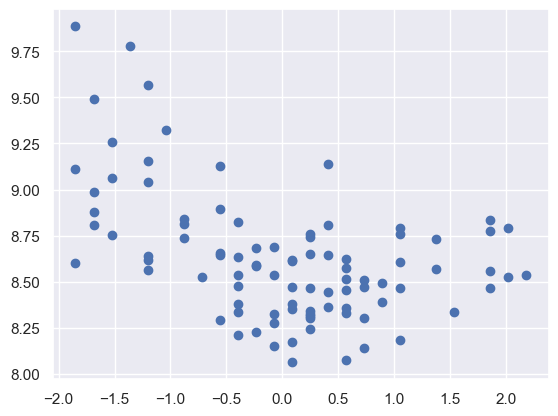

In [286]:
sns.set()
plt.scatter(df_features_summer["average_temp °c"], df_target_summer)

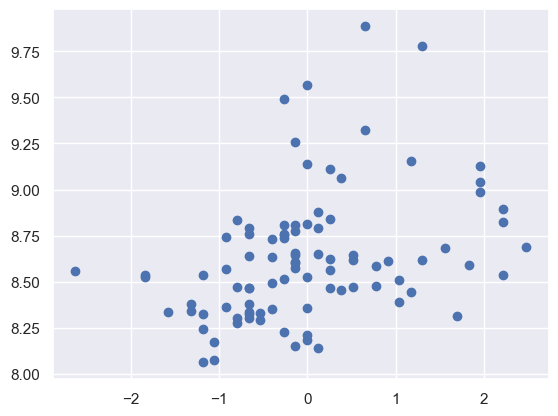

In [287]:
sns.set()
plt.scatter(df_features_summer["humidity %"], df_target_summer)

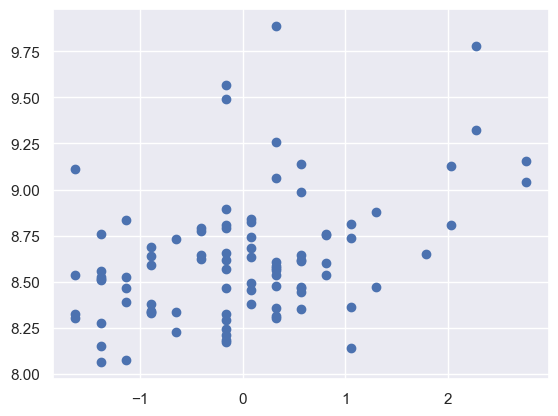

In [288]:
sns.set()
plt.scatter(df_features_summer["wind_speed km/h"], df_target_summer)

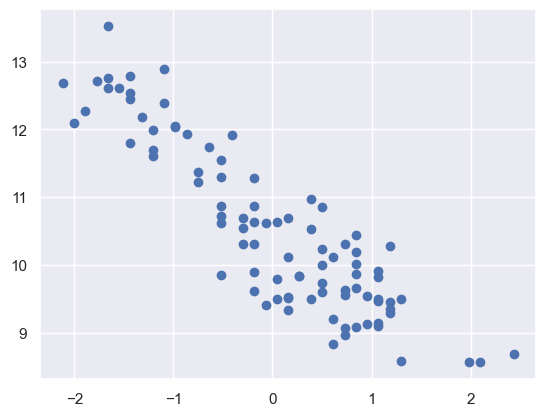

In [289]:
sns.set()
plt.scatter(df_features_fall["average_temp °c"], df_target_fall)

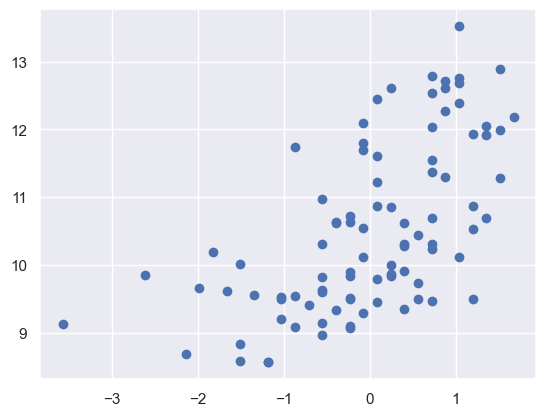

In [290]:
sns.set()
plt.scatter(df_features_fall["humidity %"], df_target_fall)

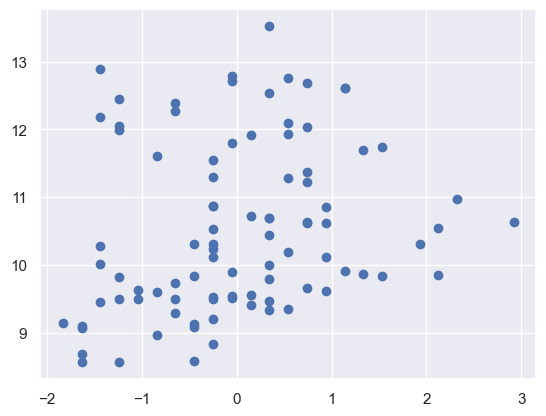

In [291]:
sns.set()
plt.scatter(df_features_fall["wind_speed km/h"], df_target_fall)

### Building Model

Use python code to build your model. Give explanation on this process.

#### Cost Function

In [292]:
# put Python code to build your model
X_winter: np.ndarray = prepare_feature(df_features_winter.to_numpy())
target_winter: np.ndarray = df_target_winter.to_numpy()
beta_winter: np.ndarray = np.zeros((4,1))
J_winter: np.ndarray = compute_cost_linreg(X_winter, target_winter, beta_winter)
print(J_winter)


X_spring: np.ndarray = prepare_feature(df_features_spring.to_numpy())
target_spring: np.ndarray = df_target_spring.to_numpy()
beta_spring: np.ndarray = np.zeros((4,1))
J_spring: np.ndarray = compute_cost_linreg(X_spring, target_spring, beta_spring)
print(J_spring)


X_summer: np.ndarray = prepare_feature(df_features_summer.to_numpy())
target_summer: np.ndarray = df_target_summer.to_numpy()
beta_summer: np.ndarray = np.zeros((4,1))
J_summer: np.ndarray = compute_cost_linreg(X_summer, target_summer, beta_summer)
print(J_summer)


X_fall: np.ndarray = prepare_feature(df_features_fall.to_numpy())
target_fall: np.ndarray = df_target_fall.to_numpy()
beta_fall: np.ndarray = np.zeros((4,1))
J_fall: np.ndarray = compute_cost_linreg(X_fall, target_fall, beta_fall)
print(J_fall)


89.96645534922662
64.80598706954646
37.29231932467947
56.16768730538267


#### Gradient descent

In [293]:
iterations: int = 1500
alpha: float = 0.01

beta_winter: np.ndarray = np.zeros((4,1))
beta_spring: np.ndarray = np.zeros((4,1))
beta_summer: np.ndarray = np.zeros((4,1))
beta_fall: np.ndarray = np.zeros((4,1))

beta_winter, J_storage_winter = gradient_descent_linreg(X_winter, target_winter, beta_winter, alpha, iterations)
print('beta_winter: \n', beta_winter)
print('J_storage_winter: \n', J_storage_winter)

beta_spring, J_storage_spring = gradient_descent_linreg(X_spring, target_spring, beta_spring, alpha, iterations)
print('beta_spring: \n', beta_spring)
print('J_storage_spring: \n', J_storage_spring)

beta_summer, J_storage_summer = gradient_descent_linreg(X_summer, target_summer, beta_summer, alpha, iterations)
print('beta_summer: \n', beta_summer)
print('J_storage_summer: \n', J_storage_summer)

beta_fall, J_storage_fall = gradient_descent_linreg(X_fall, target_fall, beta_fall, alpha, iterations)
print('beta_fall: \n', beta_fall)
print('J_storage_fall: \n', J_storage_fall)

beta_winter: 
 [[13.38187998]
 [-0.82521816]
 [ 0.2493265 ]
 [ 0.29571266]]
J_storage_winter: 
 [[88.18017579]
 [86.42944463]
 [84.71355411]
 ...
 [ 0.15237542]
 [ 0.15237542]
 [ 0.15237542]]
beta_spring: 
 [[11.2438524 ]
 [-1.61426629]
 [ 0.28645975]
 [ 0.05123477]]
J_storage_spring: 
 [[63.51954139]
 [62.2587785 ]
 [61.02318469]
 ...
 [ 0.25855814]
 [ 0.25855814]
 [ 0.25855814]]
beta_summer: 
 [[ 8.62916928]
 [-0.11681827]
 [ 0.0509714 ]
 [ 0.08119708]]
J_storage_summer: 
 [[36.55077765]
 [35.82400202]
 [35.11169824]
 ...
 [ 0.04223567]
 [ 0.04223567]
 [ 0.04223567]]
beta_fall: 
 [[10.5263    ]
 [-0.95269846]
 [ 0.29176881]
 [ 0.0400927 ]]
J_storage_fall: 
 [[55.04648832]
 [53.9477949 ]
 [52.8711531 ]
 ...
 [ 0.12184878]
 [ 0.12184878]
 [ 0.12184878]]


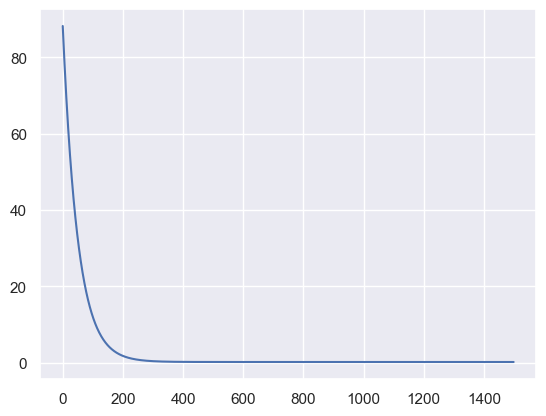

In [294]:
plt.plot(J_storage_winter)

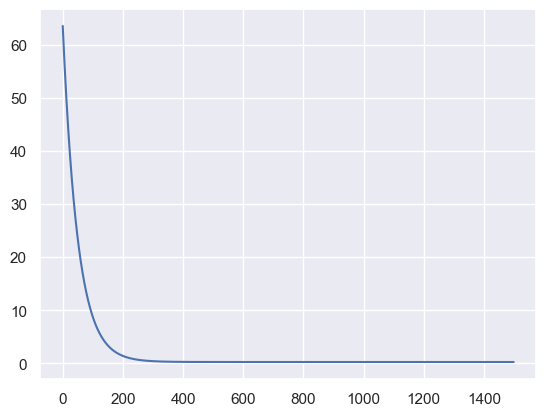

In [295]:
plt.plot(J_storage_spring)

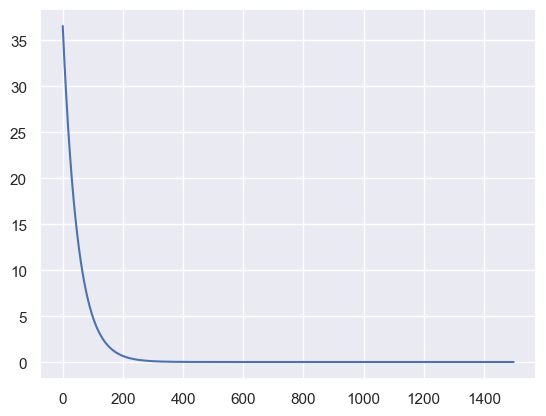

In [296]:
plt.plot(J_storage_summer)

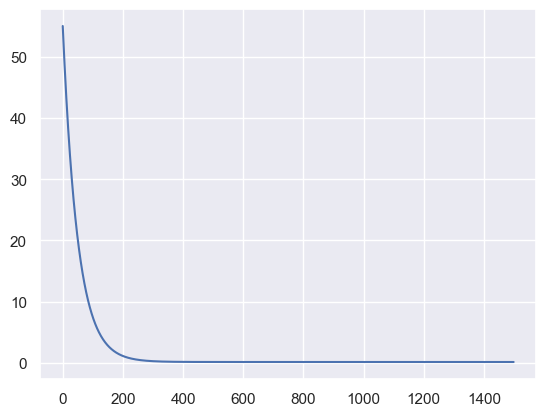

In [297]:
plt.plot(J_storage_fall)

#### Predict Linear Regression

In [298]:
# Call predict()
pred_winter: np.ndarray = predict_linreg(df_features_winter.to_numpy(), beta_winter)

# Change target to numpy array
target_winter: np.ndarray = df_target_winter.to_numpy()

print("Winter")
print(pred_winter[0], pred_winter[1], pred_winter[2])
print(target_winter[0], target_winter[1], target_winter[2])
print(pred_winter.mean(), pred_winter.std())



# Call predict()
pred_spring: np.ndarray = predict_linreg(df_features_spring.to_numpy(), beta_spring)

# Change target to numpy array
target_spring: np.ndarray = df_target_spring.to_numpy()

print("Spring")
print(pred_spring[0], pred_spring[1], pred_spring[2])
print(target_spring[0], target_spring[1], target_spring[2])
print(pred_spring.mean(), pred_spring.std())



# Call predict()
pred_summer: np.ndarray = predict_linreg(df_features_summer.to_numpy(), beta_summer)

# Change target to numpy array
target_summer: np.ndarray = df_target_summer.to_numpy()

print("Summer")
print(pred_summer[0], pred_summer[1], pred_summer[2])
print(target_summer[0], target_summer[1], target_summer[2])
print(pred_summer.mean(), pred_summer.std())



# Call predict()
pred_fall: np.ndarray = predict_linreg(df_features_fall.to_numpy(), beta_fall)

# Change target to numpy array
target_fall: np.ndarray = df_target_fall.to_numpy()

print("Fall")
print(pred_fall[0], pred_fall[1], pred_fall[2])
print(target_fall[0], target_fall[1], target_fall[2])
print(pred_fall.mean(), pred_fall.std())

Winter
[13.10826042] [13.15331982] [12.14479842]
[12.75519523] [13.17318388] [12.35783882]
13.381879984666146 0.7437006812855075
Spring
[12.38240063] [12.5990458] [12.73478992]
[13.23104313] [13.50014075] [13.9840908]
11.243852397003694 1.634175058131922
Summer
[8.82682707] [8.79941047] [8.79941047]
[9.25549376] [9.48901362] [8.80595006]
8.629169281556669 0.19380998148515968
Fall
[8.55541954] [8.83368992] [8.22841205]
[9.13074915] [8.57718275] [8.57082406]
10.526300003562916 1.1350618796849674


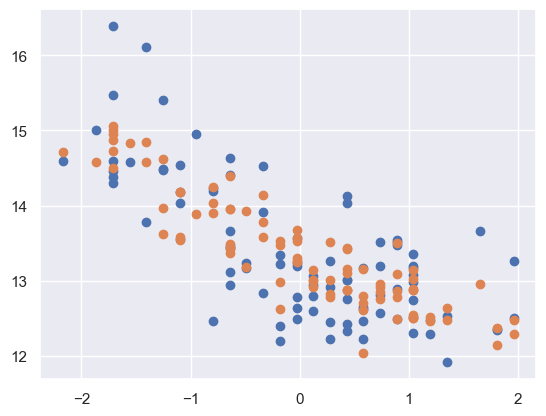

In [299]:
plt.scatter(df_features_winter["average_temp °c"],target_winter)
plt.scatter(df_features_winter["average_temp °c"],pred_winter)

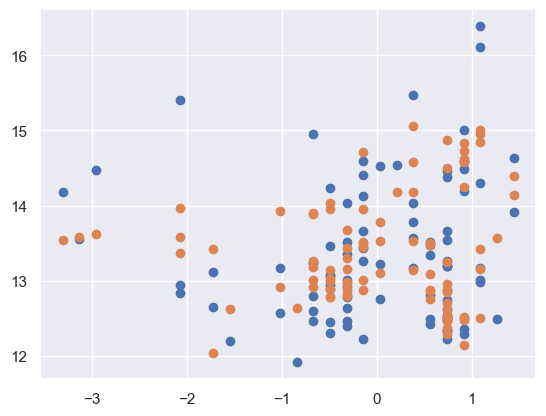

In [300]:
plt.scatter(df_features_winter["humidity %"],target_winter)
plt.scatter(df_features_winter["humidity %"],pred_winter)

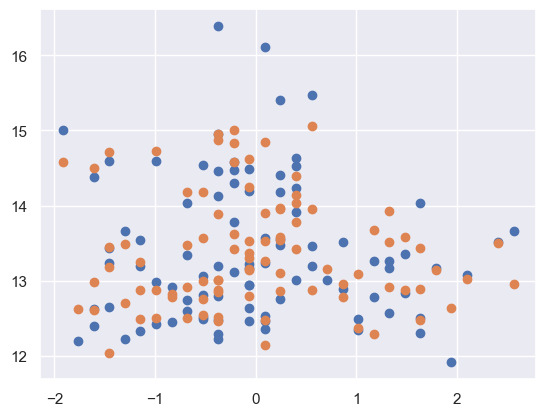

In [301]:
plt.scatter(df_features_winter["wind_speed km/h"],target_winter)
plt.scatter(df_features_winter["wind_speed km/h"],pred_winter)

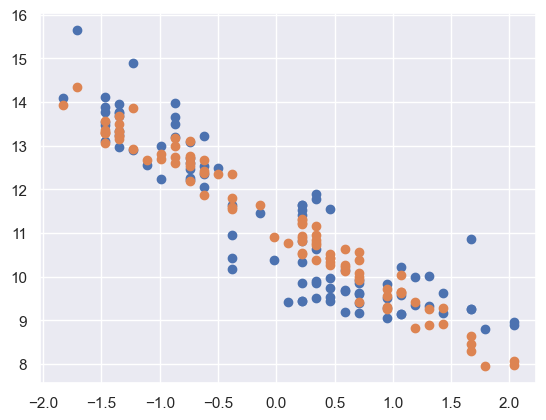

In [302]:
plt.scatter(df_features_spring["average_temp °c"],target_spring)
plt.scatter(df_features_spring["average_temp °c"],pred_spring)

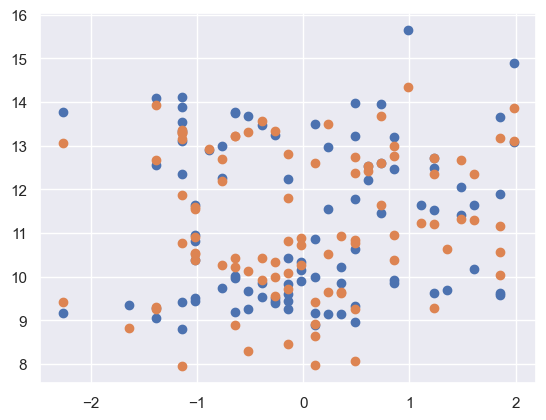

In [303]:
plt.scatter(df_features_spring["humidity %"],target_spring)
plt.scatter(df_features_spring["humidity %"],pred_spring)

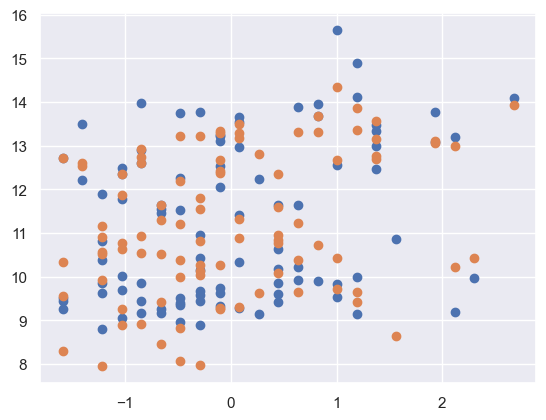

In [304]:
plt.scatter(df_features_spring["wind_speed km/h"],target_spring)
plt.scatter(df_features_spring["wind_speed km/h"],pred_spring)

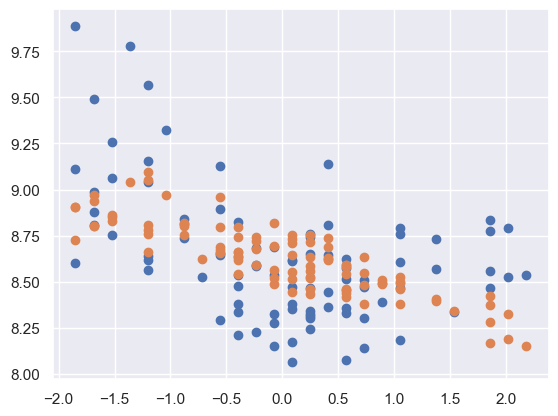

In [305]:
plt.scatter(df_features_summer["average_temp °c"],target_summer)
plt.scatter(df_features_summer["average_temp °c"],pred_summer)

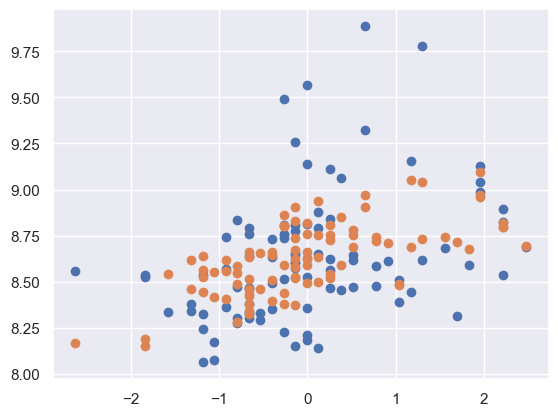

In [306]:
plt.scatter(df_features_summer["humidity %"],target_summer)
plt.scatter(df_features_summer["humidity %"],pred_summer)

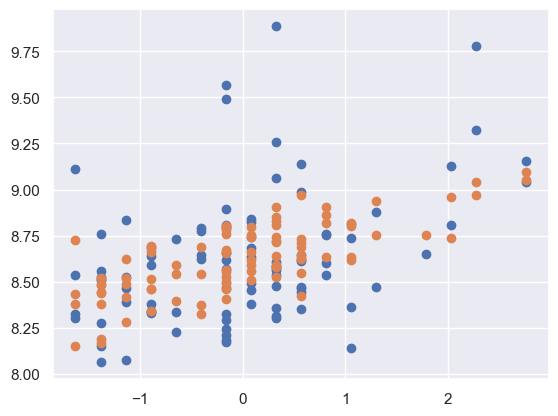

In [307]:
plt.scatter(df_features_summer["wind_speed km/h"],target_summer)
plt.scatter(df_features_summer["wind_speed km/h"],pred_summer)

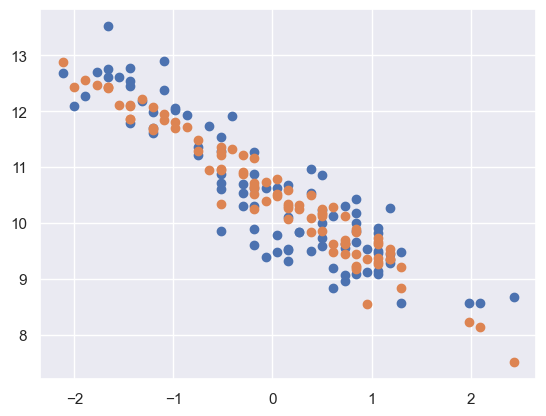

In [308]:
plt.scatter(df_features_fall["average_temp °c"],target_fall)
plt.scatter(df_features_fall["average_temp °c"],pred_fall)

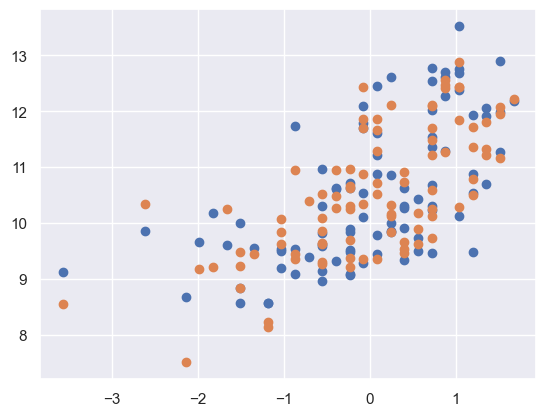

In [309]:
plt.scatter(df_features_fall["humidity %"],target_fall)
plt.scatter(df_features_fall["humidity %"],pred_fall)

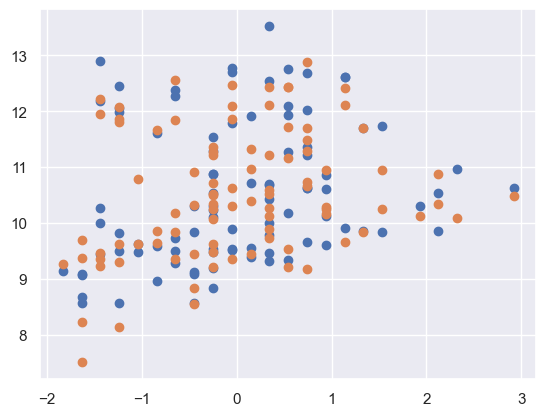

In [310]:
plt.scatter(df_features_fall["wind_speed km/h"],target_fall)
plt.scatter(df_features_fall["wind_speed km/h"],pred_fall)

### Evaluating the Model

- Describe the metrics of your choice
- Evaluate your model performance

#### Splitting Data

In [311]:
# Split the data set into training and test
df_features_train_winter, df_features_test_winter, df_target_train_winter, df_target_test_winter, df_feature_validation_winter, df_target_validation_winter = split_data(df_features_winter, df_target_winter, random_state=100, test_size=0.3)
# call build_model_linreg() function
model_winter, J_storage_winter = build_model_linreg(df_features_train_winter, df_target_train_winter)
# call the predict_linreg() method
pred_winter_validation = predict_linreg(df_feature_validation_winter.to_numpy(), model_winter['beta'], model_winter['means'], model_winter['stds'])
pred_winter: np.ndarray = predict_linreg(df_features_test_winter.to_numpy(), model_winter['beta'], model_winter['means'], model_winter['stds'])


# Split the data set into training and test
df_features_train_spring, df_features_test_spring, df_target_train_spring, df_target_test_spring, df_feature_validation_spring, df_target_validation_spring = split_data(df_features_spring, df_target_spring, random_state=100, test_size=0.3)
# call build_model_linreg() function
model_spring, J_storage_spring = build_model_linreg(df_features_train_spring, df_target_train_spring)
# call the predict_linreg() method
pred_spring: np.ndarray = predict_linreg(df_features_test_spring.to_numpy(), model_spring['beta'], model_spring['means'], model_spring['stds'])


# Split the data set into training and test
df_features_train_summer, df_features_test_summer, df_target_train_summer, df_target_test_summer, df_feature_validation_summer, df_target_validation_summer = split_data(df_features_summer, df_target_summer, random_state=100, test_size=0.3)
# call build_model_linreg() function
model_summer, J_storage_summer = build_model_linreg(df_features_train_summer, df_target_train_summer)
# call the predict_linreg() method
pred_summer: np.ndarray = predict_linreg(df_features_test_summer.to_numpy(), model_summer['beta'], model_summer['means'], model_summer['stds'])


# Split the data set into training and test
df_features_train_fall, df_features_test_fall, df_target_train_fall, df_target_test_fall, df_feature_validation_fall, df_target_validation_fall = split_data(df_features_fall, df_target_fall, random_state=100, test_size=0.3)
# call build_model_linreg() function
model_fall, J_storage_fall = build_model_linreg(df_features_train_fall, df_target_train_fall)
# call the predict_linreg() method
pred_fall: np.ndarray = predict_linreg(df_features_test_fall.to_numpy(), model_fall['beta'], model_fall['means'], model_fall['stds'])

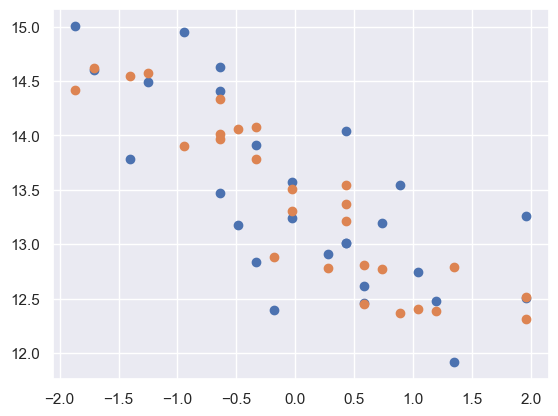

In [312]:
plt.scatter(df_features_test_winter["average_temp °c"], df_target_test_winter)
plt.scatter(df_features_test_winter["average_temp °c"], pred_winter)

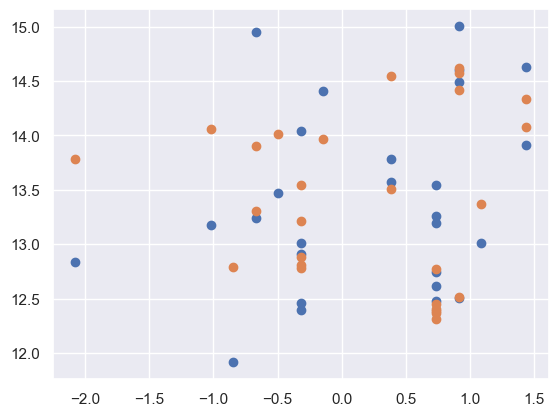

In [313]:
plt.scatter(df_features_test_winter["humidity %"], df_target_test_winter)
plt.scatter(df_features_test_winter["humidity %"], pred_winter)

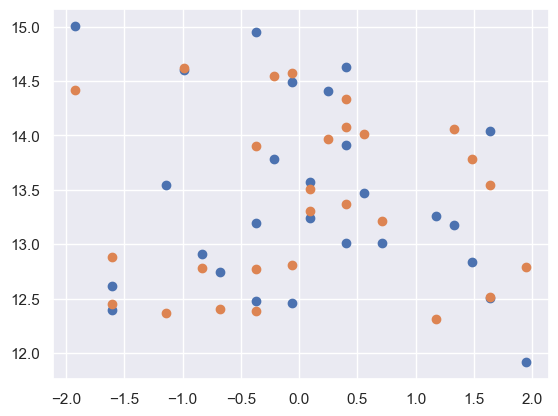

In [314]:
plt.scatter(df_features_test_winter["wind_speed km/h"], df_target_test_winter)
plt.scatter(df_features_test_winter["wind_speed km/h"], pred_winter)

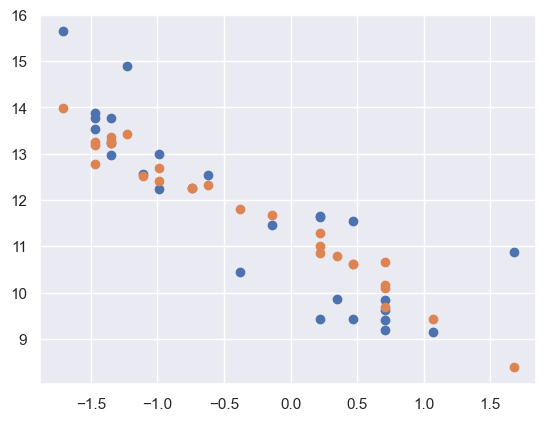

In [315]:
plt.scatter(df_features_test_spring["average_temp °c"], df_target_test_spring)
plt.scatter(df_features_test_spring["average_temp °c"], pred_spring)

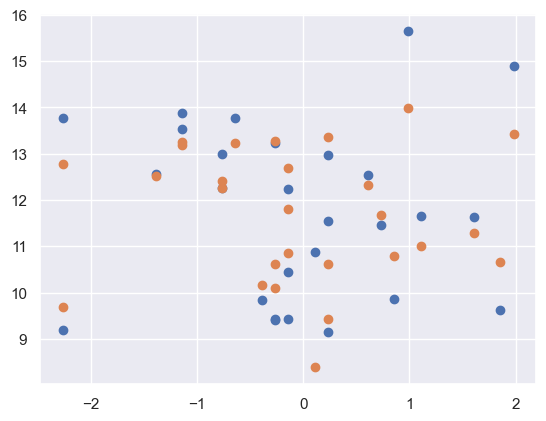

In [316]:
plt.scatter(df_features_test_spring["humidity %"], df_target_test_spring)
plt.scatter(df_features_test_spring["humidity %"], pred_spring)

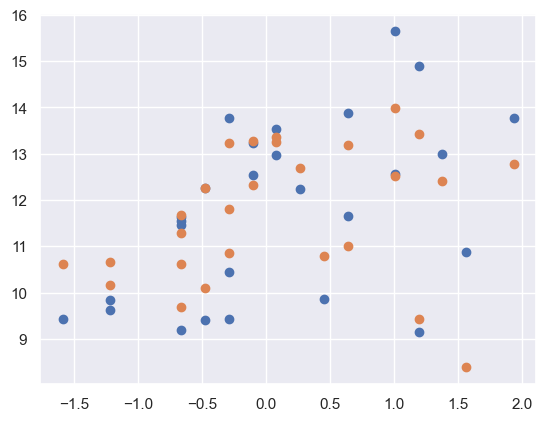

In [317]:
plt.scatter(df_features_test_spring["wind_speed km/h"], df_target_test_spring)
plt.scatter(df_features_test_spring["wind_speed km/h"], pred_spring)

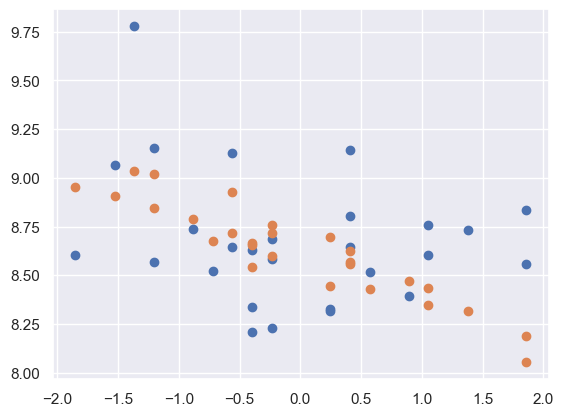

In [318]:
plt.scatter(df_features_test_summer["average_temp °c"], df_target_test_summer)
plt.scatter(df_features_test_summer["average_temp °c"], pred_summer)

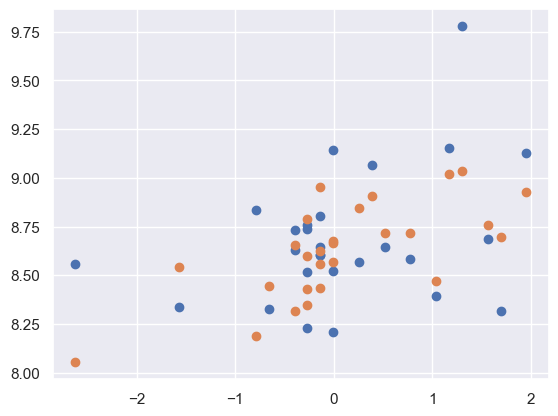

In [319]:
plt.scatter(df_features_test_summer["humidity %"], df_target_test_summer)
plt.scatter(df_features_test_summer["humidity %"], pred_summer)

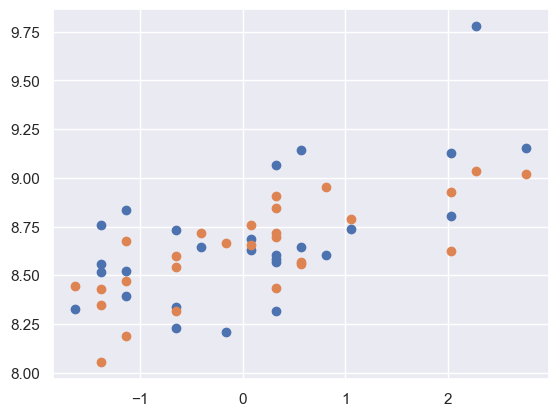

In [320]:
plt.scatter(df_features_test_summer["wind_speed km/h"], df_target_test_summer)
plt.scatter(df_features_test_summer["wind_speed km/h"], pred_summer)

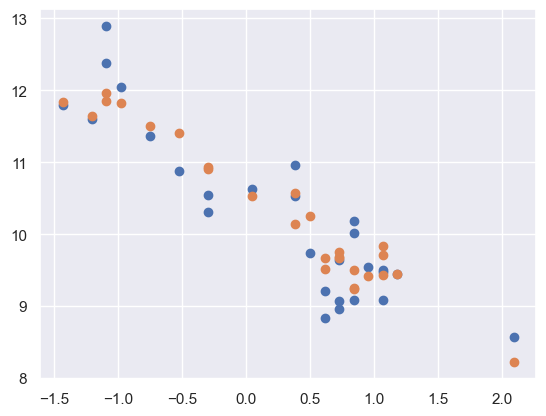

In [321]:
plt.scatter(df_features_test_fall["average_temp °c"], df_target_test_fall)
plt.scatter(df_features_test_fall["average_temp °c"], pred_fall)

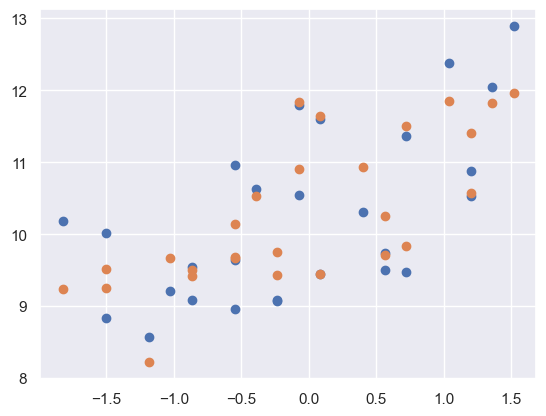

In [322]:
plt.scatter(df_features_test_fall["humidity %"], df_target_test_fall)
plt.scatter(df_features_test_fall["humidity %"], pred_fall)

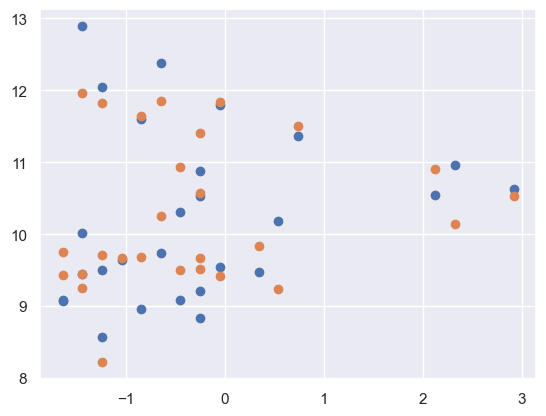

In [323]:
plt.scatter(df_features_test_fall["wind_speed km/h"], df_target_test_fall)
plt.scatter(df_features_test_fall["wind_speed km/h"], pred_fall)

#### R<sup>2</sup> Score (Coefficient of Determination)

In [324]:
target_winter_validation = df_target_validation_winter.to_numpy()
r2_winter_validation = r2_score(target_winter_validation, pred_winter_validation)

target_winter: np.ndarray = df_target_test_winter.to_numpy()
r2_winter: float = r2_score(target_winter, pred_winter)

target_spring: np.ndarray = df_target_test_spring.to_numpy()
r2_spring: float = r2_score(target_spring, pred_spring)

target_summer: np.ndarray = df_target_test_summer.to_numpy()
r2_summer: float = r2_score(target_summer, pred_summer)

target_fall: np.ndarray = df_target_test_fall.to_numpy()
r2_fall: float = r2_score(target_fall, pred_fall)

print('r2_winter_validation', r2_winter_validation)
print('r2_winter:', r2_winter)
print('r2_spring:', r2_spring)
print('r2_summer:', r2_summer)
print('r2_fall:', r2_fall)

r2_winter_validation 0.5928980407132317
r2_winter: 0.5470700452246346
r2_spring: 0.7473423477932835
r2_summer: 0.05619818188879899
r2_fall: 0.8142453525097402


#### Mean Square Error

In [325]:
mse_winter_validation = mean_squared_error(target_winter_validation, pred_winter_validation)
mse_winter: float = mean_squared_error(target_winter, pred_winter)

mse_spring: float = mean_squared_error(target_spring, pred_spring)
mse_summer: float = mean_squared_error(target_summer, pred_summer)
mse_fall: float = mean_squared_error(target_fall, pred_fall)

print('mse_winter_validation', mse_winter_validation)
print('mse_winter:', mse_winter)
print('mse_spring:', mse_spring)
print('mse_summer:', mse_summer)
print('mse_fall:', mse_fall)

mse_winter_validation 0.6414829748612102
mse_winter: 0.31469863039574714
mse_spring: 0.8603610538828328
mse_summer: 0.10614638277263445
mse_fall: 0.24892342049851415


### Improving the Model

- Improve the models by performing any data processing techniques or hyperparameter tuning.
- You can repeat the steps above to show the improvement as compared to the previous performance

Note:
- You should not change or add dataset at this step
- You are allowed to use library such as sklearn for data processing (NOT for building model)
- Make sure to have the same test dataset so the results are comparable with the previous model 
- If you perform hyperparameter tuning, it will require you to split your training data further into train and validation dataset

In [326]:
# Re-iterate the steps above with improvement

### Discussion and Analysis

- Analyze the results of your metrics.
- Explain how does your analysis and machine learning help to solve your problem statement.
- Conclusion